# **Working memory training**: Whole-brain normalized rectuitment/integration

Karolina Finc | Centre for Modern Interdisciplinary Technologies, Nicolaus Copernicus University in Toruń, Poland

**Last edited:** 12-05-2019

Step 0: Loading libraries
--------------------------------------------

In [2]:
import sys
sys.path.append("..")
import os

%matplotlib inline

import scipy.io as sio
import numpy as np
from nilearn import plotting 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from fctools import networks, figures

#---- matplotlib settings
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
plt.rcParams['font.family'] = 'Helvetica'

Step 1: Selecting subjects to analysis
--------------------------------------------

In [11]:
top_dir = '/home/finc/Dropbox/Projects/LearningBrain/'

# Selecting subjects which finished the study
groups = pd.read_csv('../data/behavioral/group_assignment.csv')

trained = (groups.group == 'Experimental') | (groups.group == 'Control')
trained_subs = groups[trained]
subs = trained_subs['sub'].values

#--- creating vectors to filter by group
experimental = (trained_subs == 'Experimental')
control = (trained_subs == 'Control')

exp_vector = experimental['group'].values
con_vector = control['group'].values

#--- dualnback - selecting subjects included into dinal analysis and creating group assignment vectors
dualnback_exclude = ['sub-13', 'sub-21', 'sub-23', 'sub-50'] # higly motion subjects in one of four sessions
dual_vector = [True if sub not in dualnback_exclude else False for sub in subs]
#exp_vector = exp_vector[dual_vector]
con_vector = con_vector[dual_vector]
subs = trained_subs['sub'][dual_vector].values

n = sum(dual_vector)
print(f'Number of subject after excluding subjects with higly motion: {n}')

Number of subject after excluding subjects with higly motion: 42


In [12]:
exp_vector & dual_vector

array([False, False, False,  True,  True,  True, False, False,  True,
       False, False,  True, False,  True,  True,  True, False,  True,
        True,  True, False, False,  True, False,  True, False,  True,
       False, False, False,  True, False, False, False,  True,  True,
       False,  True,  True, False,  True,  True, False,  True, False,
        True])

In [6]:
dual_vector 

[True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True]

Step 2: Getting modules names and color pallete
----------------------------------------

In [72]:
# Loading Power et al. (2011) labels
path_power_labels = '../support/modules.txt'

with open(path_power_labels, 'r') as f:
    power_labels = f.read()
power_labels = power_labels.split('\n')
power_labels.sort()
power_labels.remove('')

power_unique_networks = sorted(list(set(power_labels))) 

power_labels_idx = []
for label in power_labels:
    power_labels_idx.append(power_unique_networks.index(label))
    
power_labels = np.array(power_labels_idx)


# Loading Schaefer et al (2018) labels
path_schaefer_labels = '../support/schaefer_networks_300.csv'
schaefer_labels = pd.read_csv(path_schaefer_labels, header=None)[0].values
schaefer_unique_networks = sorted(list(set(schaefer_labels))) 

schaefer_labels_idx = []
for label in schaefer_labels:
    schaefer_labels_idx.append(schaefer_unique_networks.index(label))

schaefer_labels = np.array(schaefer_labels_idx)

Step 3: Calculating mean normalized network rectuitment/integration
----------------------------------------

### Normalization function

In [73]:
def normalize_networks_mean(matrix, labels, n_iter):
    '''...
    
    Args:
        matrix: (N x N)
        labels: (N, )
        n_iter: int
    '''

    n_networks = len(np.unique(labels))

    def calculate_networks_mean(matrix, labels, n_networks):
        '''... '''
        nam = np.zeros((n_networks, n_networks))

        for i in range(n_networks):
            for j in range(n_networks):
                nam[i, j] = np.mean(matrix[np.nonzero(labels == i)][:, np.nonzero(labels == j)])

        return nam

    nam = calculate_networks_mean(matrix, labels, n_networks)
    nam_null = np.zeros((n_networks, n_networks))
    labels_null = labels.copy()

    for _ in range(n_iter):
        np.random.shuffle(labels_null)
        nam_null += calculate_networks_mean(matrix, labels_null, n_networks)

    nam_null /= n_iter    

    return np.divide(nam, nam_null)

### Loading allegiance matrices

In [95]:
parcellation = 'power'

P = np.load(f'{top_dir}data/neuroimaging/03-modularity/dynamic/03-allegiance_matrices/allegiance_matrix_{parcellation}_dualnback_opt_mean.npy')
P.shape

(46, 4, 264, 264)

### Calculating mean normalized recruitment/integration

In [96]:
# Calculate mean normalized allegiance
n_net = len(eval(f'{parcellation}_unique_networks'))

norm_mean_allegiance = np.zeros((P.shape[0], P.shape[1], n_net, n_net))

for i in range(P.shape[0]):
    print(trained_subs['sub'].values[i])
    for j in range(P.shape[1]):
        norm_mean_allegiance[i, j] = normalize_networks_mean(P[i, j], eval(f'{parcellation}_labels'), 1000)

np.save(f'{top_dir}data/neuroimaging/03-modularity/dynamic/04-recruitment_integration/whole-brain_{parcellation}_normalized_mean_allegiance.npy', norm_mean_allegiance)

sub-01
sub-02
sub-04
sub-05
sub-06
sub-07
sub-08
sub-10
sub-11
sub-12
sub-13
sub-14
sub-15
sub-16
sub-18
sub-19
sub-20
sub-21
sub-23
sub-24
sub-25
sub-26
sub-27
sub-28
sub-29
sub-30
sub-33
sub-35
sub-36
sub-37
sub-39
sub-41
sub-42
sub-43
sub-44
sub-45
sub-46
sub-47
sub-48
sub-50
sub-51
sub-52
sub-53
sub-54
sub-55
sub-56


### Save results as tidy dataframe

In [97]:
# Create tidy data frame from mean allegiance values
filename = f'whole-brain_{parcellation}_normalized'
norm_mean_allegiance = np.load(f'{top_dir}data/neuroimaging/03-modularity/dynamic/04-recruitment_integration/{filename}_mean_allegiance.npy')


sessions = ['Naive', 'Early', 'Middle', 'Late']
normalized_measures = pd.DataFrame()
recruitment = pd.DataFrame()

for i, sub in enumerate(trained_subs['sub'].values):
    for j, ses in enumerate(sessions):
        for k, net1 in enumerate(eval(f'{parcellation}_unique_networks')): 
            
            networks_allegiance = pd.DataFrame()
            
            for l, net2 in enumerate(eval(f'{parcellation}_unique_networks')):
                
                norm_net_allegiance = norm_mean_allegiance[i,j,k,l]
                pre = pd.DataFrame([[sub, ses, trained_subs['group'].values[i], net1, norm_net_allegiance]], 
                                   columns=['Subject', 'Session', 'Group', 'Network', f'{net2}']) 
                
                if net1 == net2:
                    recruitment = pd.concat((recruitment, pd.DataFrame([[sub, ses, trained_subs['group'].values[i], net1, norm_net_allegiance]], 
                                   columns=['Subject', 'Session', 'Group', 'Network', 'Recruitment']))) 
                if l == 0:
                    networks_allegiance = pre
                if l > 0:
                    networks_allegiance = pd.merge(networks_allegiance, pre, on = ['Subject', 'Session', 'Group', 'Network'])
            
            normalized_measures = pd.concat((normalized_measures, networks_allegiance), axis=0)

normalized_measures.to_csv(f'{top_dir}data/neuroimaging/03-modularity/dynamic/04-recruitment_integration/{filename}_mean_allegiance_tidy.csv', 
                           index=False)
recruitment.to_csv(f'{top_dir}data/neuroimaging/03-modularity/dynamic/04-recruitment_integration/{filename}_rectuitment_tidy.csv', 
                   index=False)

-------------------------------------

### Exploration plots

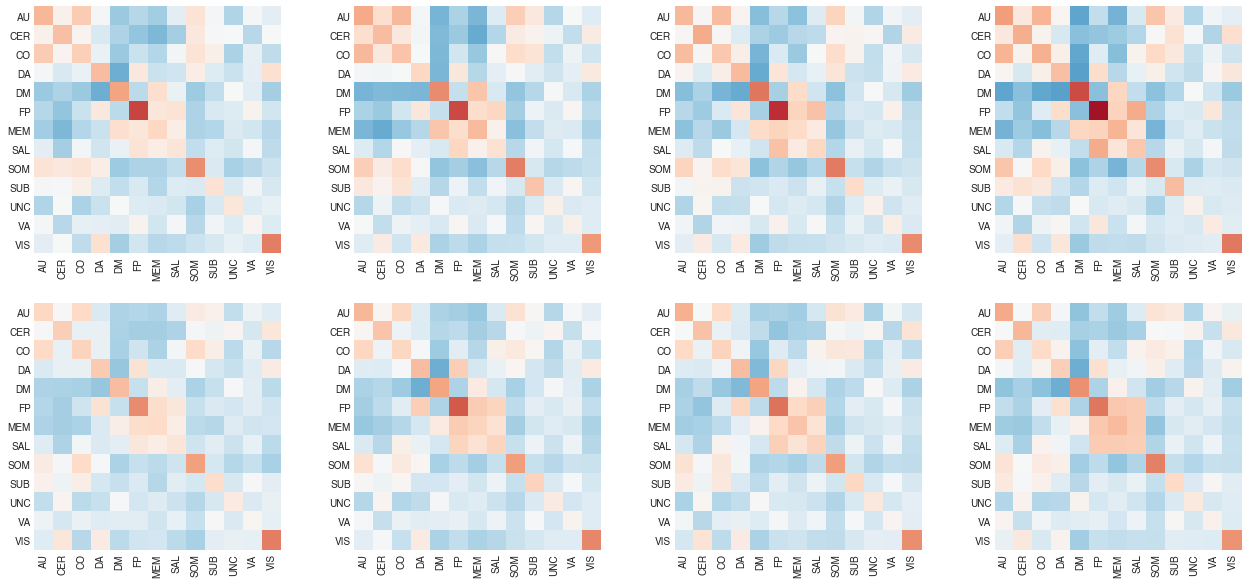

In [129]:
fig, ax = plt.subplots(2, 4)
fig.set_size_inches(22, 10)

group_vectors = [exp_vector, con_vector]
sessions = ['Naive', 'Early', 'Middle', 'Late']
group_lab = ['Experimental', 'Control']
norm_mean_allegiance_clean = norm_mean_allegiance[dual_vector]

for g, group in enumerate(group_vectors):
    for s, ses in enumerate(sessions):
        m_na = norm_mean_allegiance_clean[group, s, :, :].mean(axis=0)
        #ax[ses].imshow(m_na)
        sns.heatmap(m_na, yticklabels = np.unique(modules), 
                          xticklabels = np.unique(modules), 
                          square = True, 
                          cmap = "RdBu_r", 
                          ax=ax[g][s],
                          cbar=None, 
                          vmin = 0.6, vmax = 1.5)


### Plotting mean matrices

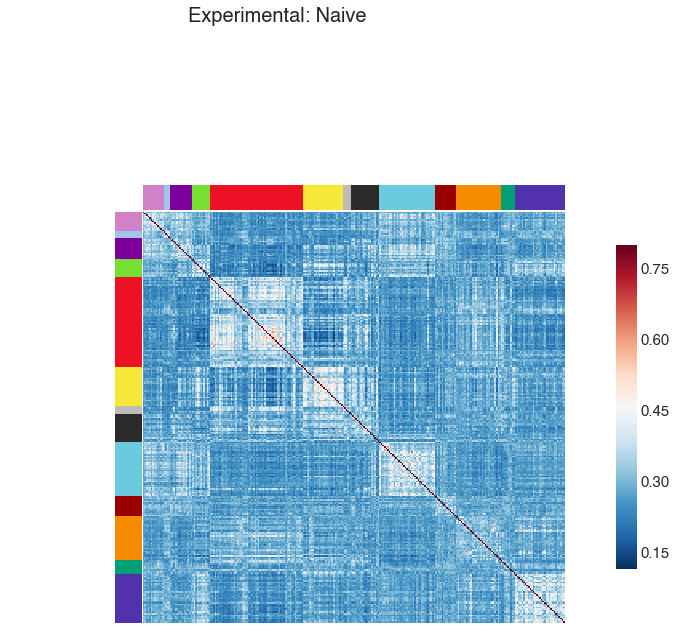

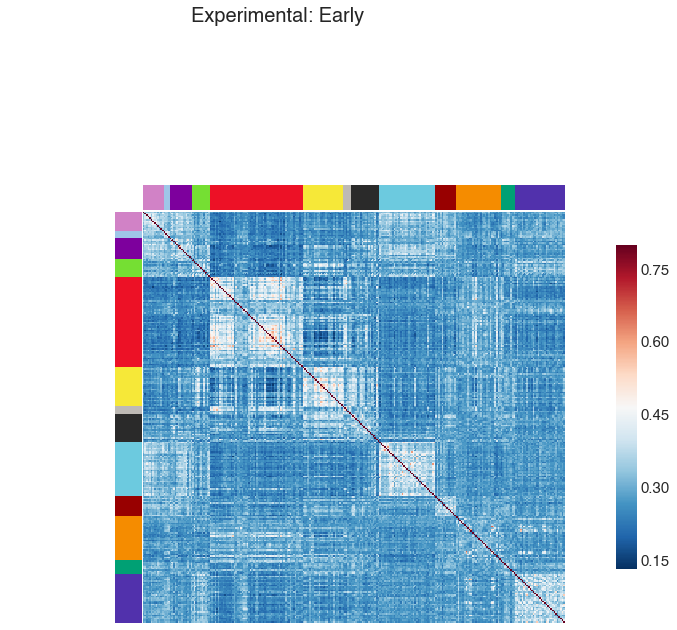

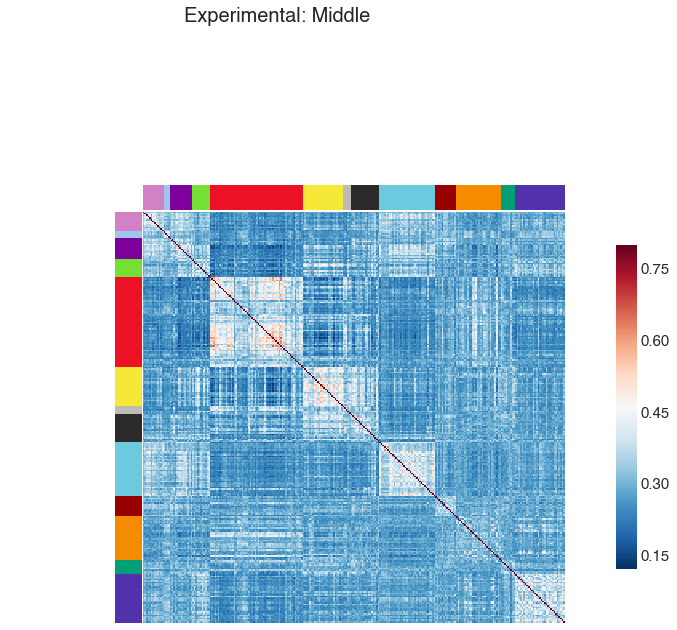

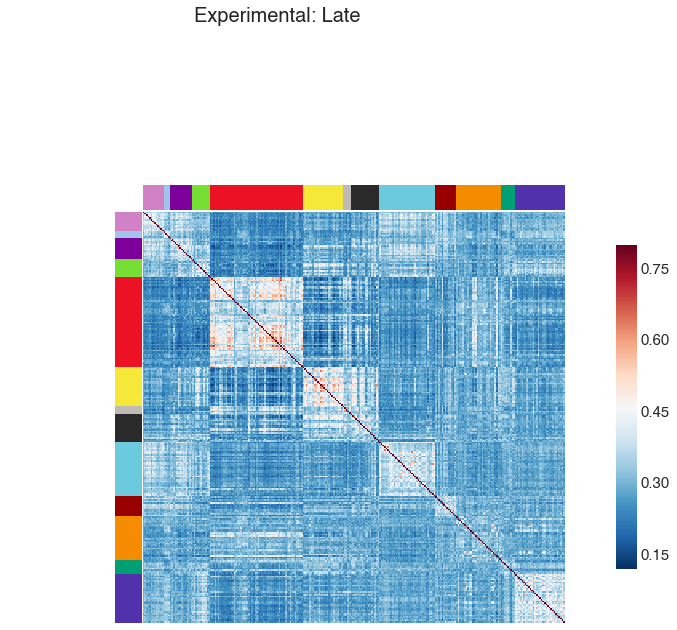

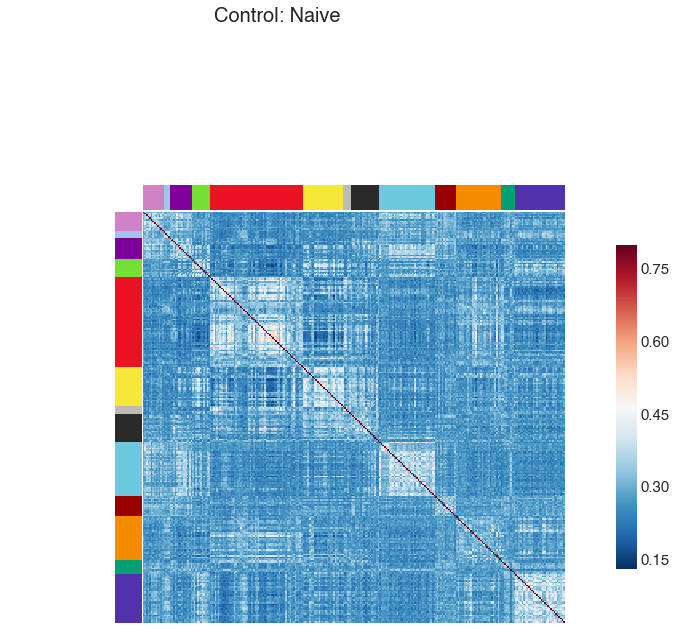

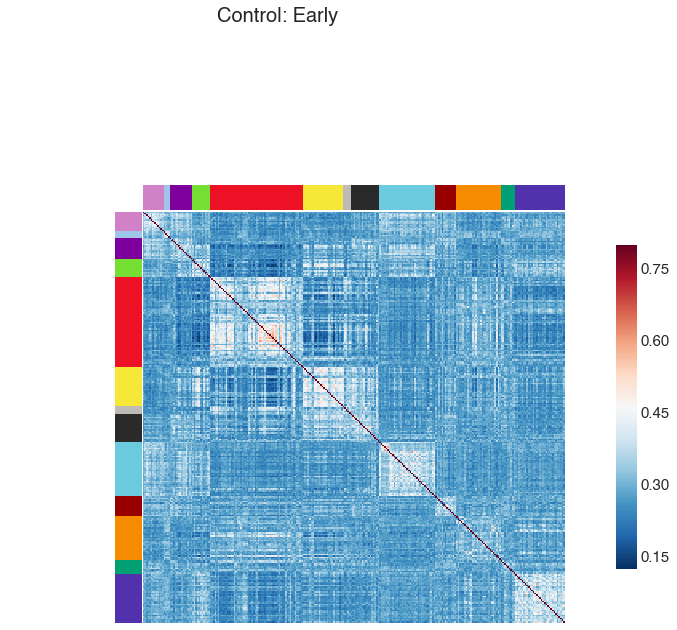

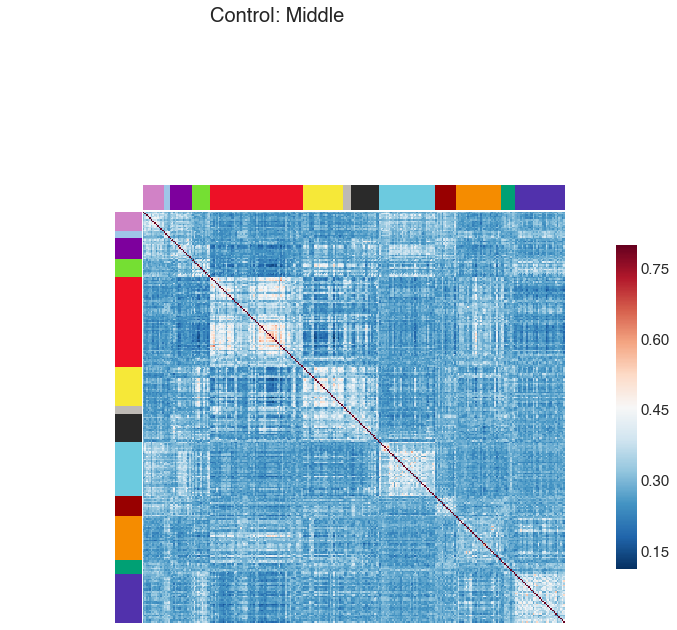

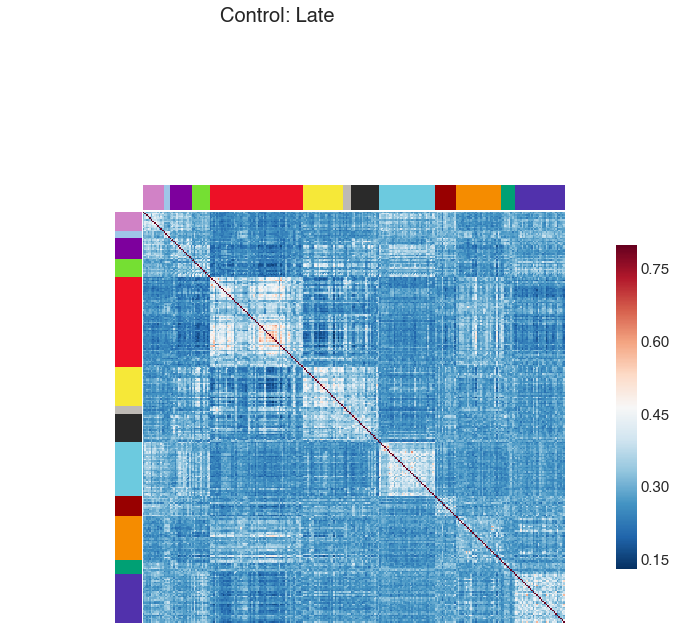

In [6]:
group_vectors = [exp_vector, con_vector]
ses_lab = ['Naive', 'Early', 'Middle', 'Late']
group_lab = ['Experimental', 'Control']

#--- generating matrix plots with colors for each network
for i, vec in enumerate(group_vectors):
    for j, ses in enumerate(ses_lab):
        M = P[vec, j, :, :].mean(axis = 0)
        ax = figures.matrix_networks_plot(M, network_colors, dpi = 100, colorbar = True, group = group_lab[i], ses = ses, suffix = None, out_dir = None)



### T-tests for mean recruitment and integration values

In [181]:
group_vectors = [exp_vector, con_vector]
group_lab = ['Experimental', 'Control']
mm_stat = np.zeros((2,13,13))
mm_pval = np.zeros((2,13,13))

for v, vec in enumerate(group_vectors):
    for i in range(13):
        for j in range(13):
            stat, pval = stats.ttest_rel(norm_mean_allegiance_clean[vec, 3, i, j], norm_mean_allegiance_clean[vec, 0, i, j])
            mm_stat[v,i,j] = stat 
            mm_pval[v,i,j] = round(pval, 4)

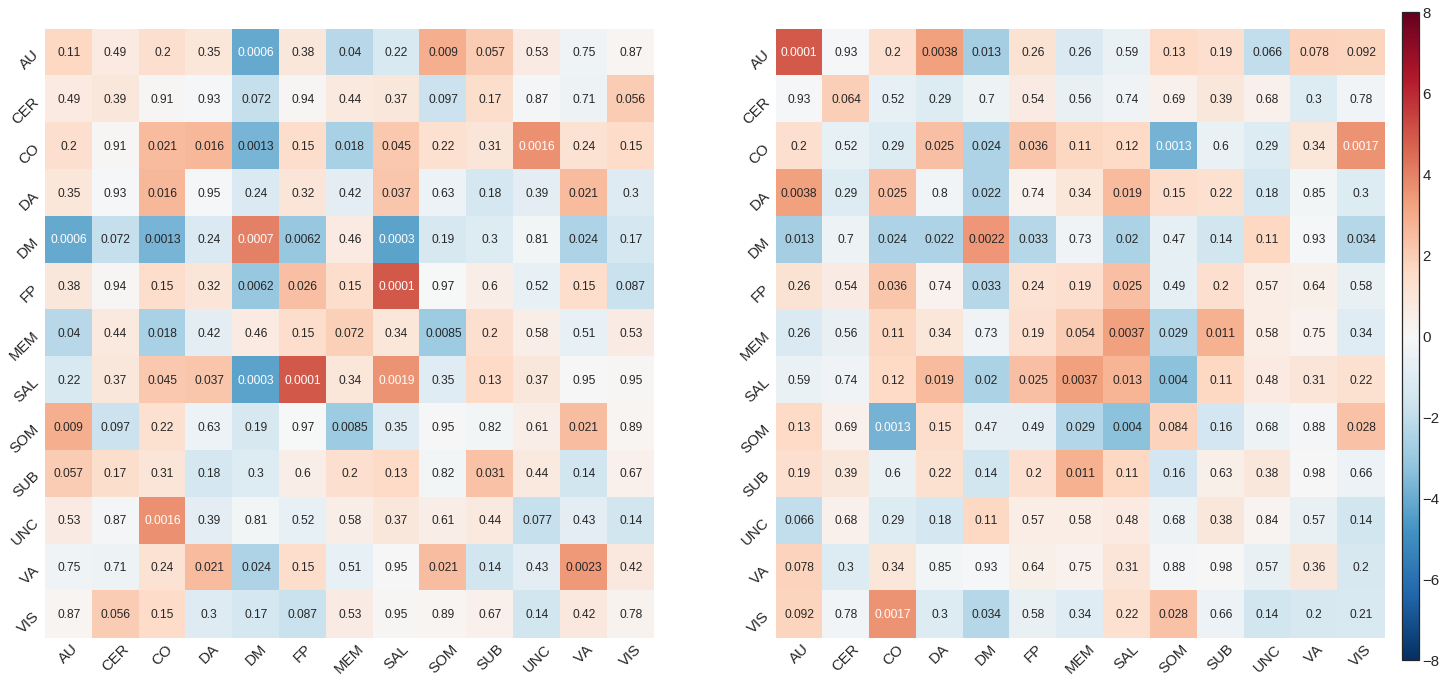

In [182]:
plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=15)     # fontsize of the axes title
plt.rc('axes', labelsize=15)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)    # fontsize of the tick labels
plt.rc('legend', fontsize=15) 
plt.rc('axes', linewidth=0)


plt.style.use('seaborn-white')
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(22, 10)
group_vectors = [exp_vector, con_vector]
group_lab = ['Experimental', 'Control']

for i, vec in enumerate(group_vectors):
        fig = plt.gcf()
        fig.set_size_inches(24, 15)

        plt.ioff()
        g = sns.heatmap(mm_stat[i, :, :], 
                        yticklabels = np.unique(modules), 
                        xticklabels = np.unique(modules), 
                        square = True, 
                        cmap = "RdBu_r", 
                        ax=axes[i],
                        vmin = -8, vmax = 8,
                        cbar=None,#,
                        annot = mm_pval[i, :, :])
        #g.set_title(f'{group_lab[i]}: {ses}', size = 15)
        g.set_xticklabels(np.unique(modules), rotation=45)
        g.set_yticklabels(np.unique(modules), rotation=45)

im = plt.gca().get_children()[0]
cax = fig.add_axes([.91, .2, .01, .6]) 
fig.colorbar(im, cax=cax, drawedges = False)

In [183]:
# Recruitment values

df_recr = pd.DataFrame()
for g, group in enumerate(group_lab):
    for n, net in enumerate(np.unique(modules)):
        x = mm_stat[g, n, n]
        y = mm_pval[g, n, n]
        result_pre = pd.DataFrame({'Group': group,
                                   'Network': net,
                                   'Recruitment_ttest': x,
                                  'Recruitment_pval': y},index = [0])               
        df_recr = df_recr.append(result_pre)       

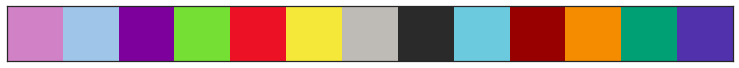

In [192]:
power264_colors = {'AU':'#d182c6',
                   'CER':'#9fc5e8',
                   'CO':'#7d009d', 
                   'DA':'#75df33', 
                   'DM':'#ed1126', 
                   'FP':'#f6e838', 
                   'MEM':'#bebab5',
                   'SAL':'#2a2a2a',
                   'SOM':'#6ccadf',
                   'SUB':'#980000',
                   'UNC':'#f58c00',
                   'VA':'#00a074', 
                   'VIS':'#5131ac'}

power_palette = (sns.color_palette(power264_colors.values()))
sns.palplot(power_palette)

In [218]:
naive = recruitment[recruitment.Session=='Naive']
late = recruitment[recruitment.Session=='Late']

In [222]:
late['Recruitment_change'] = late['Recruitment'] - naive['Recruitment']

/home/finc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [259]:
df = late.groupby(['Group','Network']).mean().reset_index()
df_diff = df[df['Group']=='Experimental']['Recruitment_change'].values - df[df['Group']=='Control']['Recruitment_change'].values 
# df_diff
df_diff

array([-0.05176558, -0.00299557,  0.06949907, -0.00269008,  0.05073265,
        0.05591171,  0.00324153,  0.00987574, -0.05738659,  0.05130646,
       -0.03888695,  0.01817597,  0.02119819])

In [263]:
df_filtered = df[df['Group']=='Experimental']
df_filtered['Recruitment_group_diff'] = df_diff

/home/finc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


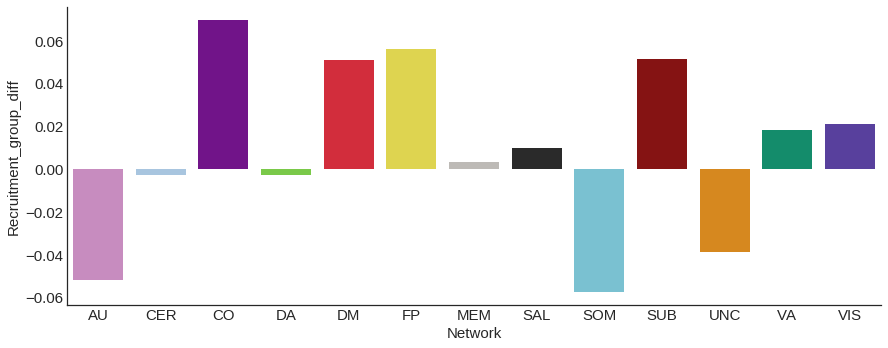

In [266]:
sns.catplot(x='Network', y='Recruitment_group_diff', #hue='Group', 
            #row='Group',
            data=df_filtered, kind='bar', height=5, aspect=2.5,
            palette = power_palette
           ) 

In [256]:
df[df['Group']=='Experimental']['Recruitment_change'].values

array([ 0.03630291,  0.04656457,  0.05560068,  0.00115839,  0.12210813,
        0.08529695,  0.05404406,  0.06198558, -0.00588959,  0.06313681,
       -0.03448797,  0.02469324,  0.00845724])

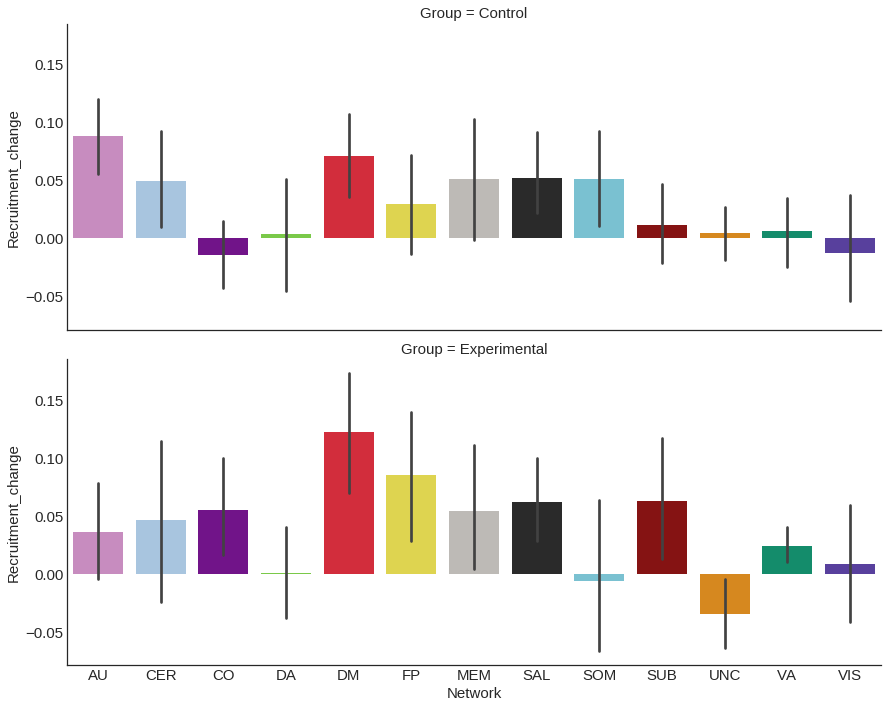

In [228]:
sns.catplot(x='Network', y='Recruitment_change', #hue='Group', 
            row='Group',
            data=late, kind='bar', height=5, aspect=2.5,
            palette = power_palette
           ) 

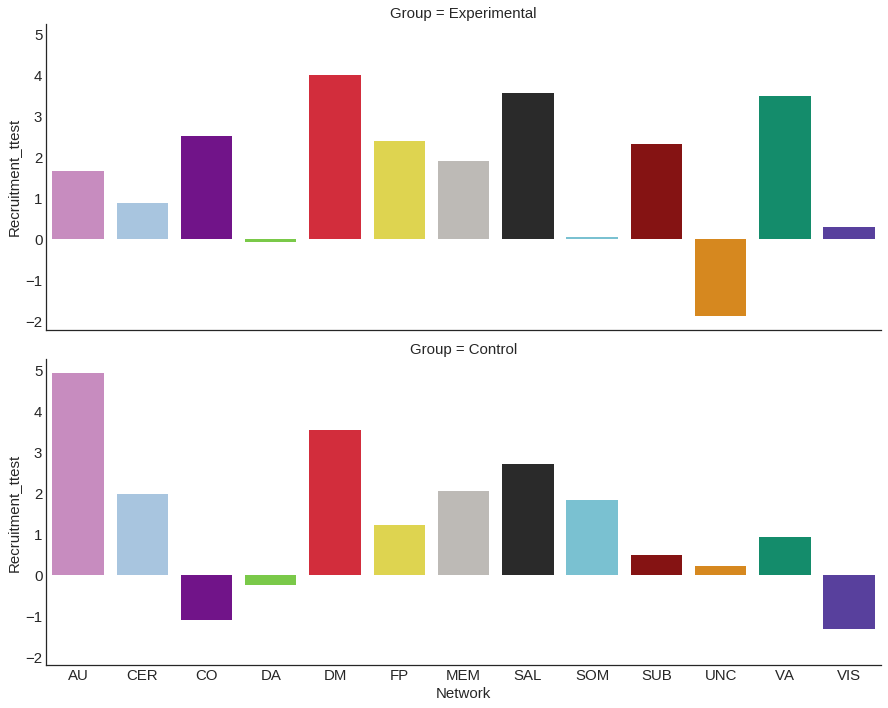

In [229]:
sns.catplot(x='Network', y='Recruitment_ttest', #hue='Group', 
            row='Group',
            data=df_recr, kind='bar', height=5, aspect=2.5,
            palette = power_palette
           ) 